In [1]:
import numpy as np
import datetime
import netCDF4
import gsw
#-------------------------------------------------------------------------|
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import cmocean
import cmocean.cm as cmo
#-------------------------------------------------------------------------|
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from scipy.io import loadmat
import xarray as xr
import math
import h5py
import pandas as pd
import re
from pathlib import Path
import os
import numpy.ma as ma
###############################
from pyresample import kd_tree, geometry, utils
from pyresample.geometry import GridDefinition
import pyproj as pyproj
from  pyproj import transform
from pyproj import Proj
# may make plotting faster
pyproj.set_use_global_context()
###############################
import sys
sys.path.append(r'/Users/houndegno/Documents/JupyterNoteBook/Prog/odi')
import odi
#-------------------------------------------------------------------------|
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Chosing SASSIE CTD data as initial data for the simulation

In [3]:
dt = 3600
Ans = 5
#wishdt = 3600*24*365*Ans
wishdt = 2635000*12*Ans
nstePs = wishdt/dt
nstePs

43916.666666666664

In [4]:
#-----------------------------------------------------------------------------------|
## SASSIE final data collected files directory -------------------------------------|
Final_SASSIE    = '/Users/houndegno/Documents/MATLAB/Data/SASSIE_DATA/Final_SASSIE_update/'
## Data files directory ------------------------------------------------------------|
ALTO_ALAMO      = 'ALTO_ALAMO/'#----------------------------------------------------|
JetSSP          = 'JetSSP/'#--------------------------------------------------------|
Shipboard_TSG   = 'Shipboard_TSG/'#-------------------------------------------------|
UpTempO         = 'UpTempO/'#-------------------------------------------------------|
uCTD            = 'uCTD/'#----------------------------------------------------------|
CastAway_CTD    = 'CastAway_CTD/'#--------------------------------------------------|
SWIFT           = 'SWIFT/'#---------------------------------------------------------|
Under_Ice_Float = 'Under_Ice_Float/'#-----------------------------------------------|
Wavegliders     = 'Wavegliders/'#---------------------------------------------------|
#-----------------------------------------------------------------------------------|
Saving_Folder = '/Users/houndegno/Documents/MATLAB/Data/SASSIE_DATA/Final_SASSIE_Coloc/UpDate_colocs/'

In [5]:
## Cast away CTD data list
CastAway_CTD_content = os.listdir(Final_SASSIE+CastAway_CTD)
CastAway_CTD_content

['SASSIE_Fall_2022_SHIPBOARD_Castaway_CTD.nc']

In [6]:
CTD_cast = xr.open_dataset(Final_SASSIE+CastAway_CTD+CastAway_CTD_content[0])
CTD_cast

<xarray.Dataset>
Dimensions:      (time: 250, depth: 311)
Coordinates:
  * time         (time) datetime64[ns] 2022-09-09T15:22:59.999998208 ... 2022...
  * depth        (depth) float64 1.0 1.296 1.591 1.887 ... 92.06 92.35 92.65
    longitude    (time) float64 ...
    latitude     (time) float64 ...
Data variables:
    pressure     (depth, time) float64 ...
    temperature  (depth, time) float64 ...
    salinity     (depth, time) float64 ...
    density      (depth, time) float64 ...
Attributes: (12/54)
    DOI:                           10.5067/SASSIE-RVCTD2
    title:                         SASSIE Arctic Field Campaign Castaway Data...
    summary:                       Castaway data collected from R/V Woldstad ...
    keywords:                      EARTH SCIENCE > OCEANS > OCEAN TEMPERATURE...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    conventions:                   CF-1.8, ACDD-1.4
    ...                            ...
    geospatial_lon_max:            -145.3295382
    geospatial_lon_units:          degrees_east
    time_coverage_start:           2022-09-09T15:23:00Z
    time_coverage_end:             2022-09-19T00:27:00Z
    uuid:                          ac6f60ba-010d-472a-8fab-57b0f8483d87
    time_coverage_duration:        P09DT09H04M00S

In [7]:
time = CTD_cast.time
time

<xarray.DataArray 'time' (time: 250)>
array(['2022-09-09T15:22:59.999998208', '2022-09-09T16:32:59.999999232',
       '2022-09-09T17:32:59.999995904', ..., '2022-09-18T23:37:00.000001792',
       '2022-09-18T23:57:00.000000768', '2022-09-19T00:27:00.000004096'],
      dtype='datetime64[ns]')
Coordinates:
  * time       (time) datetime64[ns] 2022-09-09T15:22:59.999998208 ... 2022-0...
    longitude  (time) float64 ...
    latitude   (time) float64 ...
Attributes:
    axis:                   T
    standard_name:          time
    long_name:              time
    coverage_content_type:  coordinate

In [8]:
print(2635000*12-3600*24*(365+.25))

62400.0


In [9]:
# in situ temperature [˚C]
temp = CTD_cast.temperature
# in situ pratical salinity [PSU]
sal = CTD_cast.salinity
# longitude & latitude 
lon = CTD_cast.longitude
lat = CTD_cast.latitude
# depth/pressure
pres = CTD_cast.pressure

In [10]:
# conversion of pratical salinity to absolute salinity [SA,g/kg]
SA = gsw.SA_from_SP(sal,pres,lon,lat)
# conversion of temp to potential temperature [˚C]
potemp = gsw.pt_from_t(SA,temp,pres,p_ref = 0)

Text(0.5, 1.0, 'potemp [˚C]')

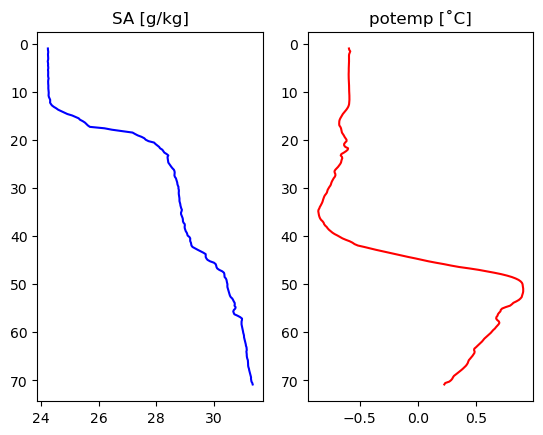

In [11]:
ji = 200
plt.figure()
ax = plt.subplot(121)
ax.plot(SA[:,ji],pres[:,ji],'-b')
ax.invert_yaxis()
plt.title('SA [g/kg]')
ax = plt.subplot(122)
ax.plot(potemp[:,ji],pres[:,ji],'-r')
ax.invert_yaxis()
plt.title('potemp [˚C]')

In [12]:
time[ji]

<xarray.DataArray 'time' ()>
array('2022-09-17T23:26:00.000000768', dtype='datetime64[ns]')
Coordinates:
    time       datetime64[ns] 2022-09-17T23:26:00.000000768
    longitude  float64 ...
    latitude   float64 ...
Attributes:
    axis:                   T
    standard_name:          time
    long_name:              time
    coverage_content_type:  coordinate

In [28]:
z_ctd = np.array(pres[:,ji]).round(1)
inonan = np.where(~np.isnan(z_ctd))[0]
z_ctd = z_ctd[inonan]
z_ctd.size

236

In [17]:
#np.diff(z_ctd)
#tRef

In [18]:
delZ   = np.array([10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.01,10.03, 10.11,
           10.32, 10.80, 11.76, 13.42, 16.04 , 19.82, 24.85,31.10, 38.42, 46.50,
           55.00, 63.50, 71.58]) #,

In [23]:
# MITgcn 1D config depth levels: 23 into 235 levels
z_mitgcm = np.cumsum(delZ)
z_mitgcm.size

23

In [21]:
## Input data
### tRef:
tRef = potemp[inonan,ji]
### sRef:
sRef = sal[inonan,ji]

In [22]:
tRef.size

236

In [24]:
TREF = np.ones(z_mitgcm.size)
SREF = np.ones(z_mitgcm.size)
for i in np.arange(z_mitgcm.size):
    idepth = (np.absolute(z_ctd - z_mitgcm[i])).argmin()
    TREF[i] = tRef[idepth]
    SREF[i] = sRef[idepth]

Text(0.5, 1.0, 'potemp [˚C]')

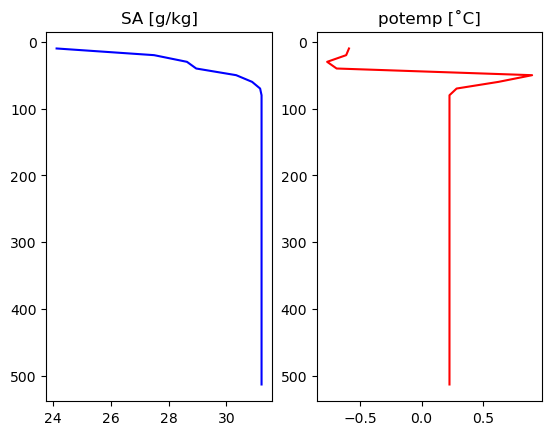

In [25]:
plt.figure()
ax = plt.subplot(121)
ax.plot(SREF,z_mitgcm,'-b')
ax.invert_yaxis()
plt.title('SA [g/kg]')
ax = plt.subplot(122)
ax.plot(TREF,z_mitgcm,'-r')
ax.invert_yaxis()
plt.title('potemp [˚C]')

In [27]:
tRef.size 

236

In [29]:
tRef = np.array(tRef)
#tRef

In [30]:
sRef = np.array(sRef)
#sRef

In [ ]:
# creating a binary files for sRef and tRef

# to create ==> h.astype('>f4').tofile('bathy.bin')
TREF.astype('>f4').tofile('TempRef.bin')
SREF.astype('>f4').tofile('SalRef.bin')
# to read ==> h = np.fromfile('bathy.bin', '>f4').reshape(ny, nx)

In [ ]:
# Learning how to group 

In [ ]:
#import MITgcmutils as mitgcm

In [ ]:
#help(mitgcm.rdmds)

rept = '/Users/houndegno/Documents/MATLAB/Data/SASSIE_DATA/MITgcm_experiments/SelfExpMITgcm/T*'

zinga = mitgcm.rdmds(rept,[0,100,11000])
np.squeeze(zinga).shape

np.squeeze(zinga)

In [31]:
Rep_fil = '/Users/houndegno/Documents/MATLAB/Data/SASSIE_DATA/MITgcm_experiments/1D_OJH/1D_ocean_ice_column/run/mnc_test_0020/'#17_for_5m/'#03/'

# Content of folder

In [32]:
os.listdir(Rep_fil)

['monitor_grid.0000000000.t001.nc',
 'sice.0000000000.t001.nc',
 'grid.t001.nc',
 'phiHydLow.0000000000.t001.nc',
 'tave.0000000000.t001.nc',
 'kpp_timeave.0000000000.t001.nc',
 'sice_tave.0000000000.t001.nc',
 'state.0000000000.t001.nc',
 'kpp_state.0000000000.t001.nc',
 'monitor_seaice.0000000000.t001.nc',
 'monitor.0000000000.t001.nc',
 'phiHyd.0000000000.t001.nc',
 'monitor_exf.0000000000.t001.nc']

# ==> State

In [33]:
state = xr.open_dataset(Rep_fil+'state.0000000000.t001.nc')
state

<xarray.Dataset>
Dimensions:  (T: 1831, Xp1: 2, Y: 1, Z: 23, X: 1, Yp1: 2, Zl: 23)
Coordinates:
  * T        (T) datetime64[ns] 2022-09-17 2022-09-18 ... 2027-09-20T20:00:00
  * Xp1      (Xp1) float64 0.0 5e+03
  * Y        (Y) float64 2.5e+03
  * Z        (Z) float64 -1.0 -3.0 -5.0 -7.0 -9.0 ... -39.0 -41.0 -43.0 -45.0
  * X        (X) float64 2.5e+03
  * Yp1      (Yp1) float64 0.0 5e+03
  * Zl       (Zl) float64 0.0 -2.0 -4.0 -6.0 -8.0 ... -38.0 -40.0 -42.0 -44.0
Data variables:
    iter     (T) int32 ...
    U        (T, Z, Y, Xp1) float32 ...
    V        (T, Z, Yp1, X) float32 ...
    Temp     (T, Z, Y, X) float32 ...
    S        (T, Z, Y, X) float32 ...
    Eta      (T, Y, X) float32 ...
    W        (T, Zl, Y, X) float32 ...
Attributes: (12/20)
    MITgcm_version:  checkpoint66g
    build_host:      49b2ae9eb454
    build_date:      Thu Oct  5 19:28:46 UTC 2023
    MITgcm_URL:      http://mitgcm.org
    MITgcm_tag_id:   1.2326 2017/04/24
    MITgcm_mnc_ver:  0.9
    ...              ...
    nSy:             1
    nPx:             1
    nPy:             1
    Nx:              1
    Ny:              1
    Nr:              23

In [34]:
Time = state.T
U = np.squeeze(np.array(state.U)).T.mean(axis=0)
V = np.squeeze(np.array(state.V)).T.mean(axis=0)
W = np.squeeze(np.array(state.W)).T
S = np.squeeze(np.array(state.S)).T
Temp = np.squeeze(np.array(state.Temp)).T
Eta = np.squeeze(np.array(state.Eta)).T
Z = np.squeeze(np.array(state.Z))

In [37]:
np.diff(Z)

array([-2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2.])

In [38]:
Z

array([ -1.,  -3.,  -5.,  -7.,  -9., -11., -13., -15., -17., -19., -21.,
       -23., -25., -27., -29., -31., -33., -35., -37., -39., -41., -43.,
       -45.])

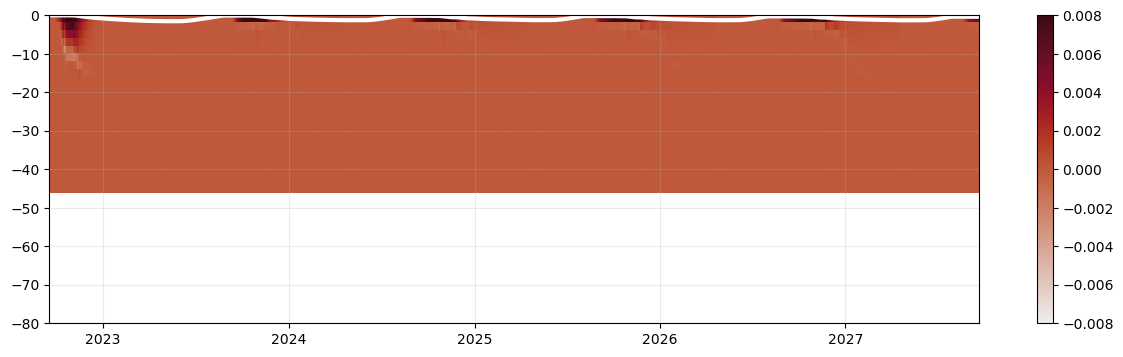

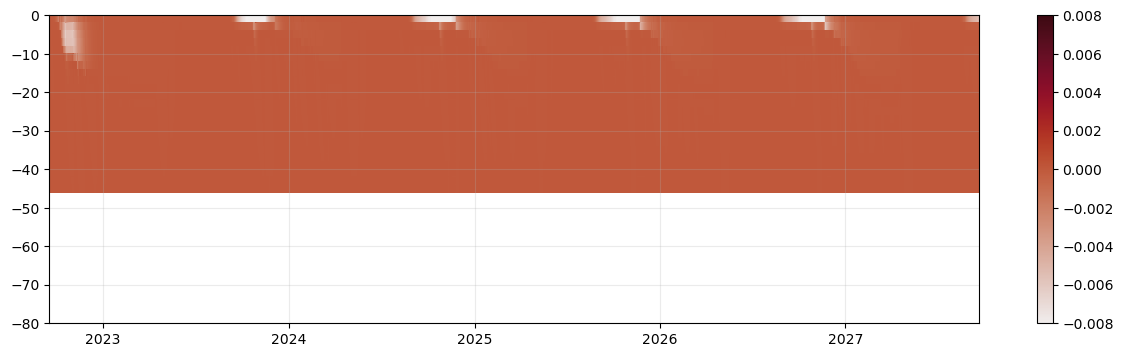

In [39]:
fig = plt.figure(figsize=[15,4], num=1);plt.clf();
a = plt.pcolor(Time,Z,U,cmap='cmo.amp')
a.set_clim(-0.008,0.008)
cb = plt.colorbar(a)
plt.plot(Time,Eta,'-w',linewidth='3')
plt.ylim(-80,0)
plt.grid(alpha=.25)

fig = plt.figure(figsize=[15,4], num=2);plt.clf();
a = plt.pcolor(Time,Z,V,cmap='cmo.amp')
a.set_clim(-0.008,0.008)
cb = plt.colorbar(a)
plt.ylim(-80,0)
plt.grid(alpha=.25)

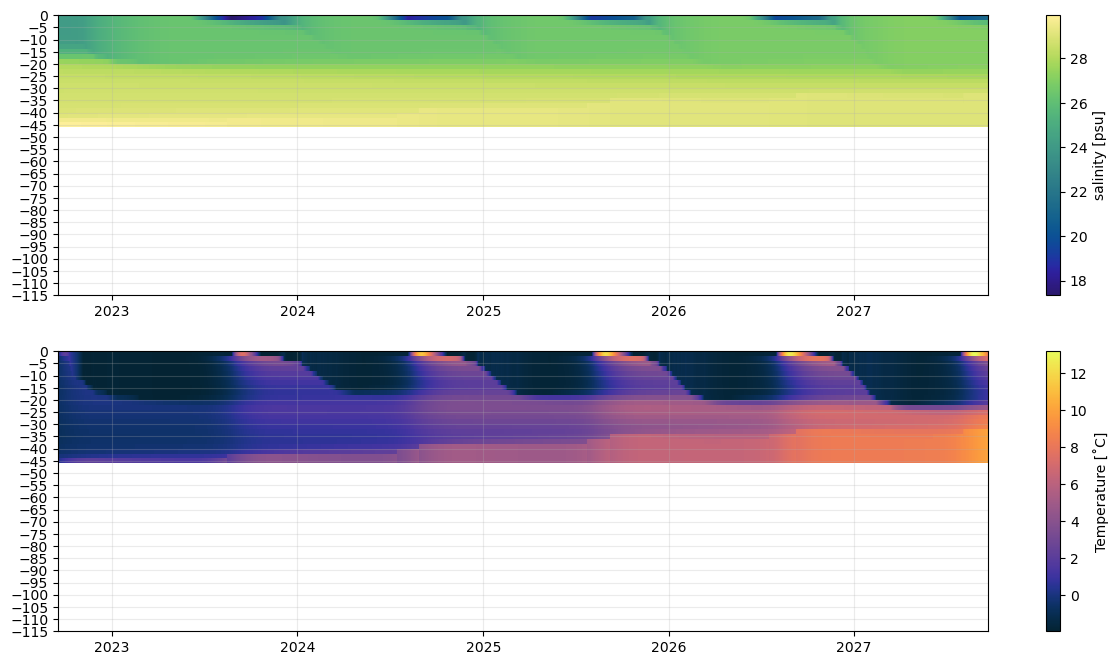

In [40]:
fig = plt.figure(figsize=[15,8], num=1);plt.clf();
plt.subplot(211)
a = plt.pcolormesh(Time,Z,S,cmap='cmo.haline')
#a.set_clim(-0.008,0.008)
cb = plt.colorbar(a,label='salinity [psu]')
#plt.plot(Time,Eta,'-r',linewidth='3')
plt.yticks(np.arange(-115,0.1,5))
#plt.ylim(-50,-2.50)
plt.grid(alpha=.25)
plt.subplot(212)
#fig = plt.figure(figsize=[15,4], num=2);plt.clf();
a = plt.pcolormesh(Time,Z,Temp,cmap='cmo.thermal')
#a.set_clim(-0.008,0.008)
cb = plt.colorbar(a,label='Temperature [˚C]')
#plt.plot(Time,Eta,'-r',linewidth='3')
plt.yticks(np.arange(-115,0.1,5))
#plt.ylim(-80,-2.5)
plt.grid(alpha=.25)

In [41]:
state.Z

<xarray.DataArray 'Z' (Z: 23)>
array([ -1.,  -3.,  -5.,  -7.,  -9., -11., -13., -15., -17., -19., -21., -23.,
       -25., -27., -29., -31., -33., -35., -37., -39., -41., -43., -45.])
Coordinates:
  * Z        (Z) float64 -1.0 -3.0 -5.0 -7.0 -9.0 ... -39.0 -41.0 -43.0 -45.0
Attributes:
    long_name:  vertical coordinate of cell center
    units:      meters
    positive:   up

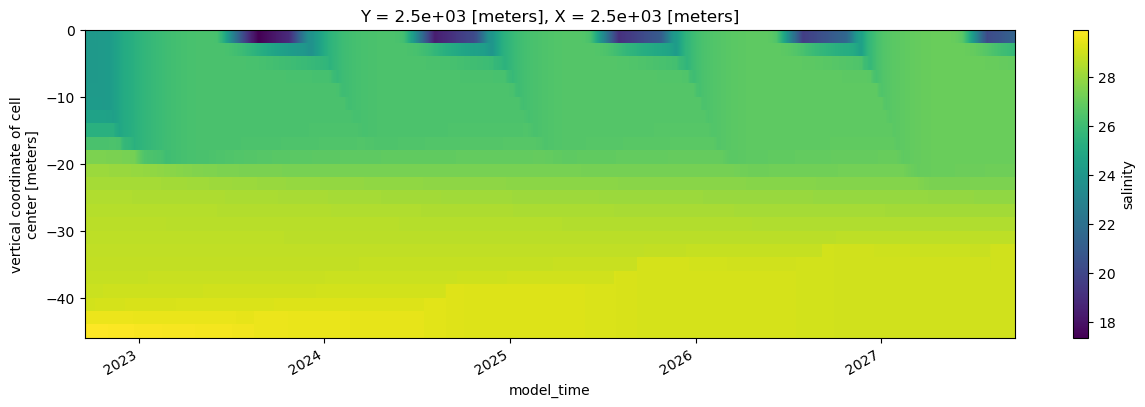

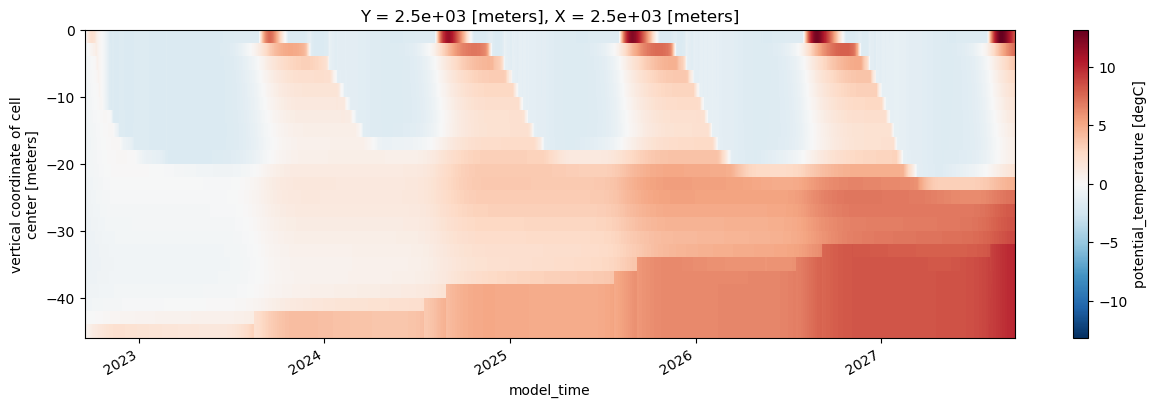

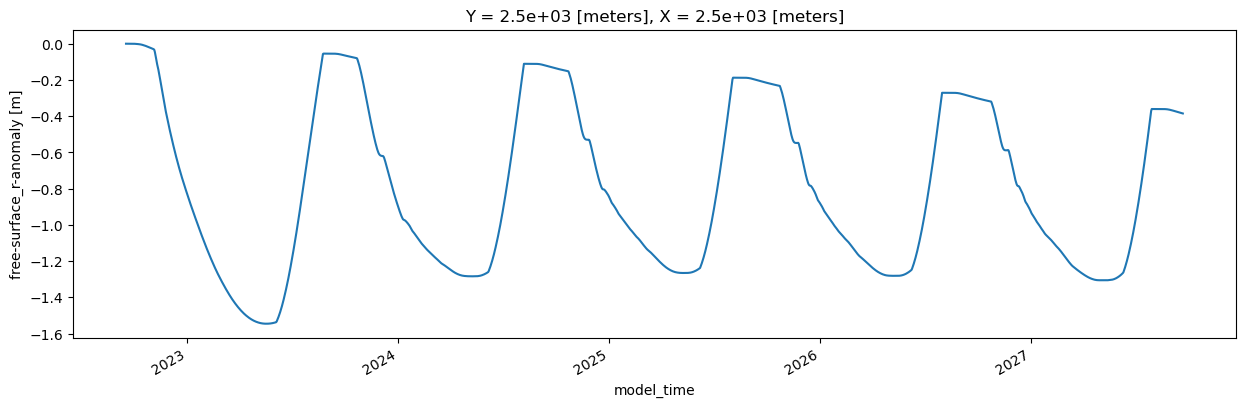

In [42]:
fig = plt.figure(figsize=[15,4], num=1);plt.clf();
state.S.T.plot()
fig = plt.figure(figsize=[15,4], num=2);plt.clf();
state.Temp.T.plot()
fig = plt.figure(figsize=[15,4], num=3);plt.clf();
state.Eta.T.plot()

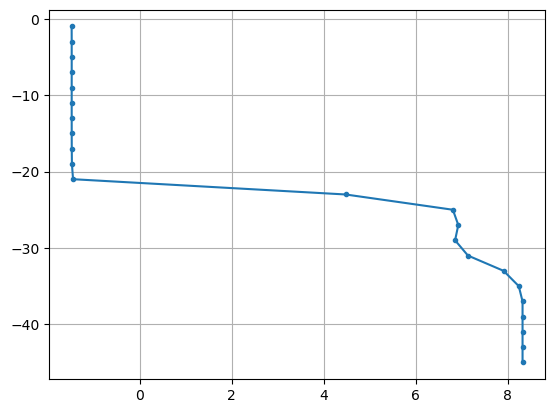

In [43]:
plt.plot(np.squeeze(state.Temp[-180,:]).T,state.Z, '.-')
plt.grid()

In [ ]:
tave = xr.open_dataset(Rep_fil+'tave.0000000000.t001.nc')
tave

In [ ]:
sice = xr.open_dataset(Rep_fil+'sice_tave.0000000000.t001.nc')
sice

In [ ]:
state_a = state.rename_dims({'T':'time'})
state_a = state_a.rename_vars({'T':'time'})
eta = np.squeeze(state_a['Eta']); 
eta = eta.reset_coords(['X','Y'], drop=True) 
eta

sice_a = sice.rename_dims({'T':'time'})
sice_a = sice_a.rename_vars({'T':'time'})

siheff = np.squeeze(sice_a['si_HEFFtave']); 
siheff = siheff.reset_coords(['X','Y'], drop=True) 
siheff

siarea = np.squeeze(sice_a['si_AREAtave']); 
siarea = siarea.reset_coords(['X','Y'], drop=True) 
siarea

# map eta to the time levels of siheff
eta_at_siheff = eta.interp_like(siheff)
eta_at_siheff.plot()
eta.plot()

In [ ]:
fig = plt.figure(figsize=[15,4], num=3);plt.clf();
eta.plot()
eta_at_siheff.plot()
(eta_at_siheff + siheff*910/1027).plot()
siheff.plot()
siarea.plot()
plt.grid()

In [ ]:
fig = plt.figure(figsize=[10,4], num=1);plt.clf();
sice.si_EmPmRtave.plot()
fig = plt.figure(figsize=[10,4], num=2);plt.clf();
sice.si_QNETtave.plot()
fig = plt.figure(figsize=[10,4], num=3);plt.clf();
sice.si_QSWtave.plot()
fig = plt.figure(figsize=[10,4], num=4);plt.clf();
sice.si_HEFFtave.plot()
fig = plt.figure(figsize=[10,4], num=4);plt.clf();
sice.si_AREAtave.plot()

In [ ]:
kpp = xr.open_dataset(Rep_fil+'kpp_timeave.0000000000.t001.nc')
kpp

In [ ]:
fig = plt.figure(figsize=[10,4], num=1);plt.clf();
kpp.KPPviscAz.T.plot()
plt.title(kpp.KPPviscAz.name)

fig = plt.figure(figsize=[10,4], num=2);plt.clf();
kpp.KPPdiffKzT.T.plot()
plt.title(kpp.KPPdiffKzT.name)


fig = plt.figure(figsize=[10,4], num=3);plt.clf();
kpp.KPPdiffKzS.T.plot()
plt.title(kpp.KPPdiffKzS.name)

fig = plt.figure(figsize=[10,4], num=4);plt.clf();
kpp.KPPghatKS.T.plot()
plt.title(kpp.KPPghatKS.name)

fig = plt.figure(figsize=[10,4], num=5);plt.clf();
kpp.KPPHBL.T.plot()
plt.title(kpp.KPPHBL.name)

In [ ]:
kpp_state = xr.open_dataset(Rep_fil+'kpp_state.0000000000.t001.nc')
kpp_state

In [ ]:
fig = plt.figure(figsize=[10,4], num=1);plt.clf();
kpp_state.KPPviscAz.T.plot()
fig = plt.figure(figsize=[10,4], num=2);plt.clf();
kpp_state.KPPdiffKzT.T.plot()
fig = plt.figure(figsize=[10,4], num=3);plt.clf();
kpp_state.KPPdiffKzS.T.plot()
fig = plt.figure(figsize=[10,4], num=4);plt.clf();
kpp_state.KPPGHAT.T.plot()
fig = plt.figure(figsize=[10,4], num=5);plt.clf();
kpp_state.KPPHBL.T.plot()

In [ ]:
(Temp2[:,0:10]).T.plot();

plt.figure()
for i in range(4):
    Temp2[:,i].plot()